In [ ]:
# default_exp sampler.subset

# Subset Monte Carlo sampler

> Sampler class for subset Monte Carlo sampling

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
from qsam.sampler.base import Sampler, protocol_subset_occurence
from qsam.sampler.tree import Variable, Constant
import numpy as np

In [ ]:
#export
class SubsetSampler(Sampler):
        
    def stats(self, err_params=None):
        _protocol_Aws = self.tree.constants
        if err_params is not None:
            self.tree.constants = protocol_subset_occurence(self.protocol_locgrps, self.protocol_wgts_combis, err_params)
        else:
            self.tree.constants = protocol_subset_occurence(self.protocol_locgrps, self.protocol_wgts_combis, self.err_params)
        
        v_L = self.tree.variance
        p_L = self.tree.rate
        delta = self.tree.delta
        delta_var = self.tree.norm_variance
        
        self.tree.constants = _protocol_Aws
        if isinstance(v_L,np.ndarray) and isinstance(p_L,(int,float)):
            p_L = np.zeros_like(v_L)
        
        return p_L, np.sqrt(v_L), p_L+delta, np.sqrt(v_L+delta_var)
    
    def wplus1(self, tree_node, circuit):
        Aws = self.tree.constants[circuit.id]
        sampled_subsets = [n.name for n in tree_node.children]
        unsampled_Aws = {k:v for k,v in Aws.items() if k not in sampled_subsets}
        if unsampled_Aws:
            next_important_subset = max(unsampled_Aws, key=lambda k: unsampled_Aws.get(k))
            subset_candidates = sampled_subsets + [next_important_subset]
        else:
            subset_candidates = sampled_subsets
        return subset_candidates
    
    def ERV(self, tree_node, circuit):

        subset_candidates = self.wplus1(tree_node, circuit)
        
        # ERV
        _min_path_weight = self.tree.min_path_weight
        self.tree.min_path_weight = 0
        
        erv_deltas = np.ma.zeros(shape=len(subset_candidates))
        delta = self.tree.delta
        v_L = self.tree.variance
        
        for i, subset in enumerate(subset_candidates):
            
            if circuit._ff_det and not any(subset):
                erv_deltas[i] = np.ma.masked
                continue
            
            _tree_node = self.tree.add(subset, parent=tree_node, cid=circuit.id, nodetype=Constant)
            children = _tree_node.children
            if len(children) == 0:
                __tree_node_minus = self.tree.add(None, parent=_tree_node, nodetype=Variable)
                __tree_node_plus = self.tree.add('FAIL', parent=_tree_node, nodetype=Variable, marked=True)
            elif len(children) == 1:
                if children[0].marked:
                    __tree_node_minus = self.tree.add(None, parent=_tree_node, nodetype=Variable)
                    __tree_node_plus = children[0]
                else:
                    __tree_node_minus = children[0]
                    __tree_node_plus = self.tree.add('FAIL', parent=_tree_node, nodetype=Variable, marked=True)
            elif len(children) == 2:
                __tree_node_minus, __tree_node_plus = children
            else:
                raise Exception("Subset nodes not allowed to have more than 2 children.")
                
            _tree_node.counts += 1
            
            __tree_node_minus.counts += 1
            _delta = self.tree.delta
            v_L_minus = self.tree.variance
            __tree_node_minus.counts -= 1
            
            __tree_node_plus.counts += 1
            v_L_plus = self.tree.variance
            __tree_node_plus.counts -= 1
            
            _tree_node.counts -= 1
            
            _v_L = __tree_node_plus.rate * v_L_plus + __tree_node_minus.rate * v_L_minus
            erv_delta = np.abs(v_L - _v_L + _delta - delta)
            erv_deltas[i] = erv_delta
            
            if _tree_node.counts == 0: self.tree.detach(_tree_node)
            if __tree_node_plus.counts == 0: self.tree.detach(__tree_node_plus)
            if __tree_node_minus.counts == 0: self.tree.detach(__tree_node_minus)
        
        self.tree.min_path_weight = _min_path_weight
        idx = np.argmax(erv_deltas)
        return subset_candidates[idx], erv_deltas[idx]
    
    def optimize(self, tree_node, circuit, grp_probs):
        # wgts_combis = self.protocol_wgts_combis[circuit.id]
        # wgts_combis = self.wplus1(tree_node, circuit)
        # idx = np.random.choice(len(wgts_combis))
        # grp_wgts = wgts_combis[idx]
        grp_wgts, erv = self.ERV(tree_node, circuit)
        locgrps = self.protocol_locgrps[circuit.id]
        flocs = self.err_model.choose_w(locgrps, grp_wgts)
        return {'grp_wgts': grp_wgts, 'flocs': flocs, 'erv': erv}
    
    @property
    def tree(self):
        return list(self.trees.values())[0]
    
    def run(self, n_samples, pmax, err_params=None, callbacks=[]):
        self.err_params = err_params if err_params else pmax
        super().run(n_samples, err_params=pmax, callbacks=callbacks)

Total:   0%|          | 0/1 [00:00<?, ?it/s]

p_phy=5.00E-02:   0%|          | 0/100 [00:00<?, ?it/s]

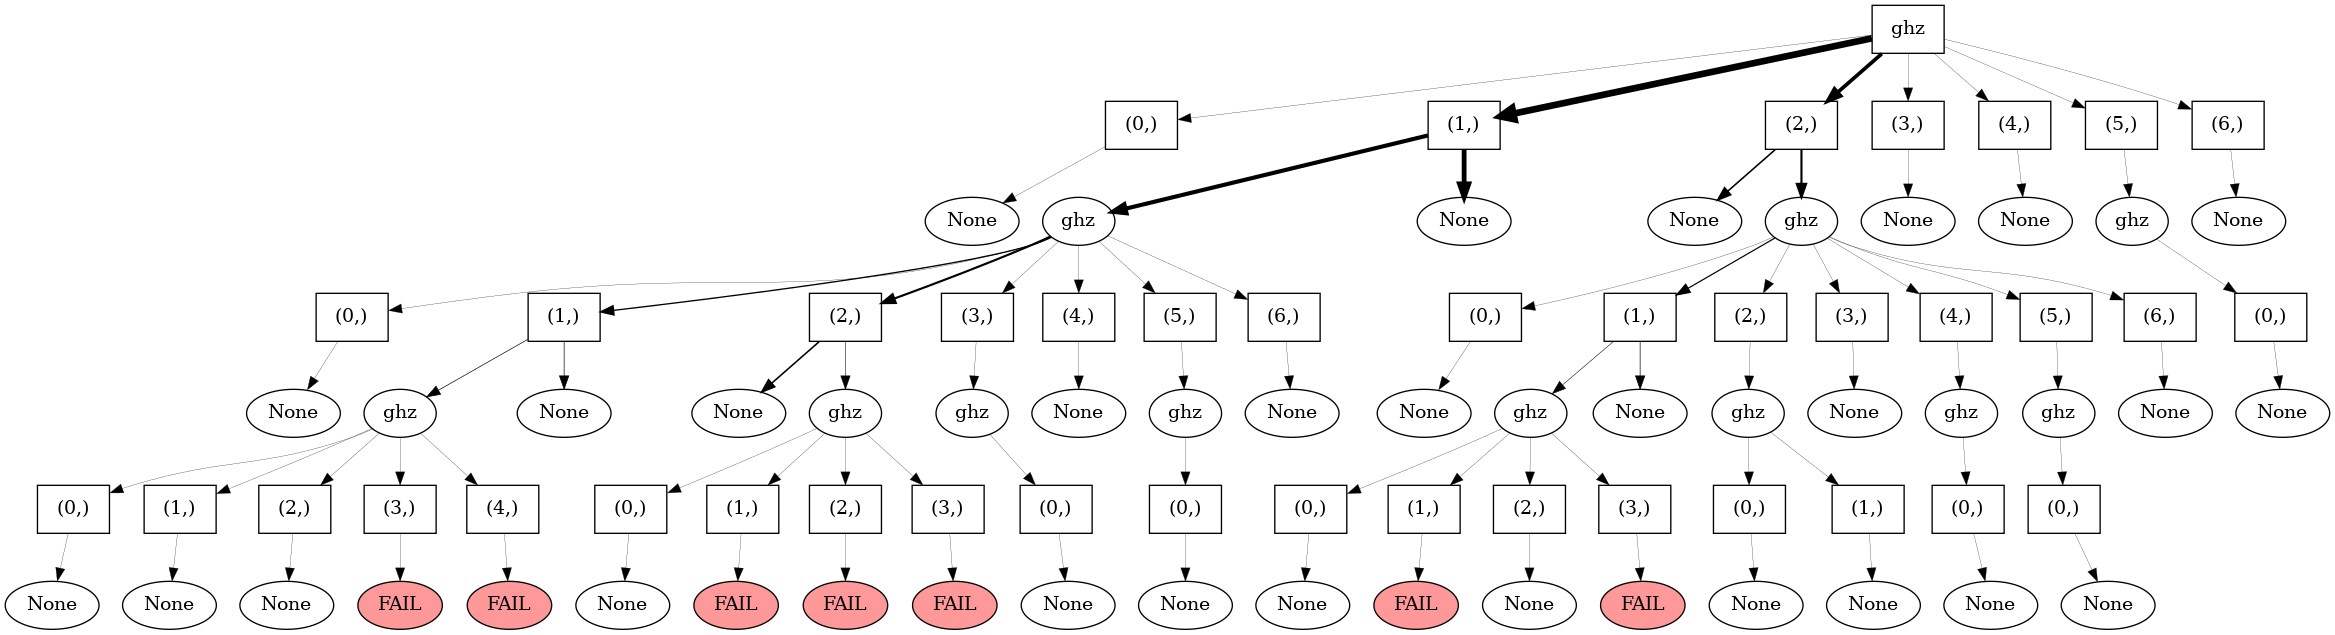

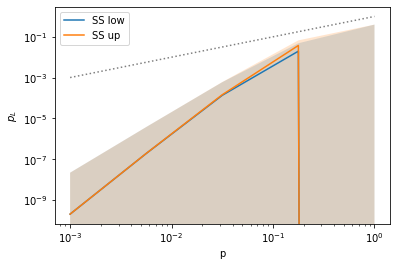

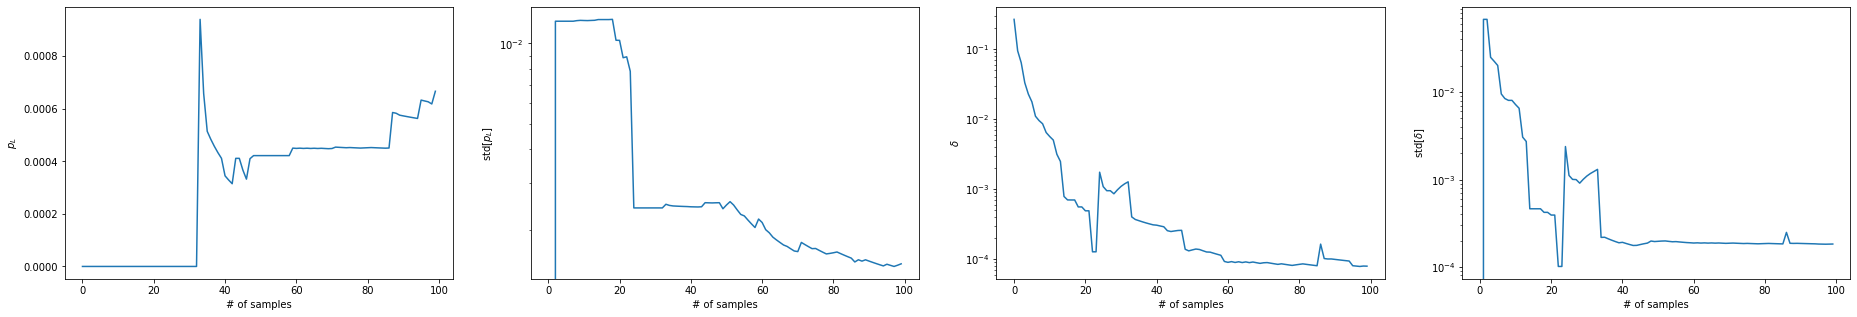

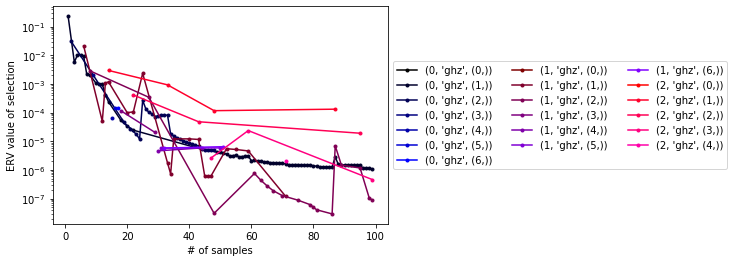

In [ ]:
from qsam.examples import ghz3,ghz_stab
from qsam.sim.stabilizer import StabilizerSimulator as CHP
from qsam.noise import E1
from qsam.callbacks import *

sample_range = np.logspace(-3,0,5)
e = E1()

sam = SubsetSampler(ghz3, CHP, err_model=e)
callbacks = [
    PlotStats(),
    RelStdTarget(target=0.5),
    StatsPerSample(),
    ErvPerSample()
    # VerboseCircuitExec()
]
sam.run(100, pmax=[0.05], err_params={'p': sample_range}, callbacks=callbacks)
sam.tree.draw()

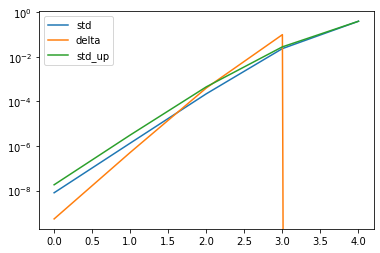

In [ ]:
import matplotlib.pyplot as plt

stats = sam.stats()
plt.plot(stats[1], label='std')
plt.plot(stats[2], label='delta')
plt.plot(stats[3], label='std_up')
plt.yscale('log')
plt.legend()